In [11]:
!wandb login 6c2c9e426d778cb5f8ebd597263a155a1c4bcb11

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [23]:
import wandb
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

api = wandb.Api()

entity = "cezary17"
project = "alsatian-quantized"
sweep_id_1 = "gfydu713"
sweep_id_2 = "r47igts8"

In [29]:
sweep_1 = api.sweep(f"{entity}/{project}/{sweep_id_1}")
sweep_2 = api.sweep(f"{entity}/{project}/{sweep_id_2}")

def collect_data(sweep, name):
    runs = sweep.runs

    run_data = []
    for run in runs:
        run_info = {
            "run_id": run.id,
            "name": run.name,
            "state": run.state,
            "config": run.config,
        }
        summary = run.summary
        run_info["model_architecture"] = summary["model_architecture"]
        run_info["original_test_accuracy"] = summary["original_test_accuracy"]
        run_info["quantized_test_accuracy"] = summary["quantized_test_accuracy"]

        run_data.append(run_info)

    data = pl.DataFrame(run_data).with_columns(pl.col("config").struct.unnest()).drop("config")
    data.write_parquet(name)

collect_data(sweep_1, 'sweep_data_1.parquet')
collect_data(sweep_2, 'sweep_data_2.parquet')

In [35]:
data_1 = pl.read_parquet("sweep_data_1.parquet")
data_2 = pl.read_parquet("sweep_data_2.parquet")


def show_plot(data):

    data_sorted = data.sort("original_test_accuracy", descending=True)

    models = data_sorted["model_architecture"].to_list()
    original_acc = data_sorted["original_test_accuracy"].to_list()
    quantized_acc = data_sorted["quantized_test_accuracy"].to_list()

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    x = np.arange(len(models))

    bars1 = ax.bar(x - bar_width/2, original_acc, bar_width, 
                label='Original Accuracy', color="lightblue", alpha=0.8)
    bars2 = ax.bar(x + bar_width/2, quantized_acc, bar_width,
                label='Quantized Accuracy', color="lightcoral", alpha=0.8)

    ax.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('OG vs Quantized Accuracy (Stanford-Dogs)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=90)
    ax.legend(loc='upper right', frameon=True, shadow=True)

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=6)

    add_value_labels(bars1)
    add_value_labels(bars2)

    ax.set_ylim(0, max(max(original_acc), max(quantized_acc)) * 1.15)

    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


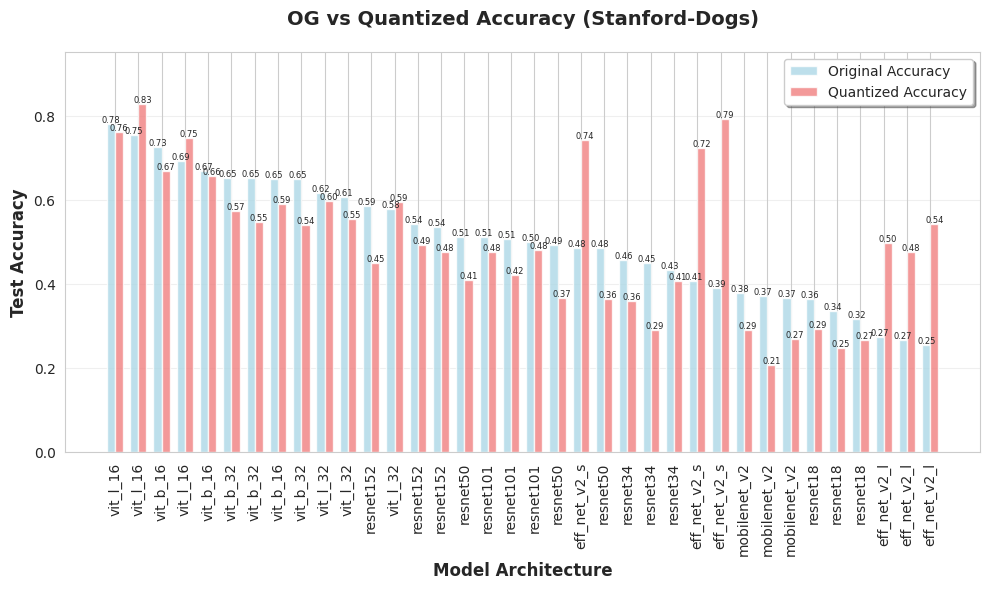

In [38]:
show_plot(data_1)

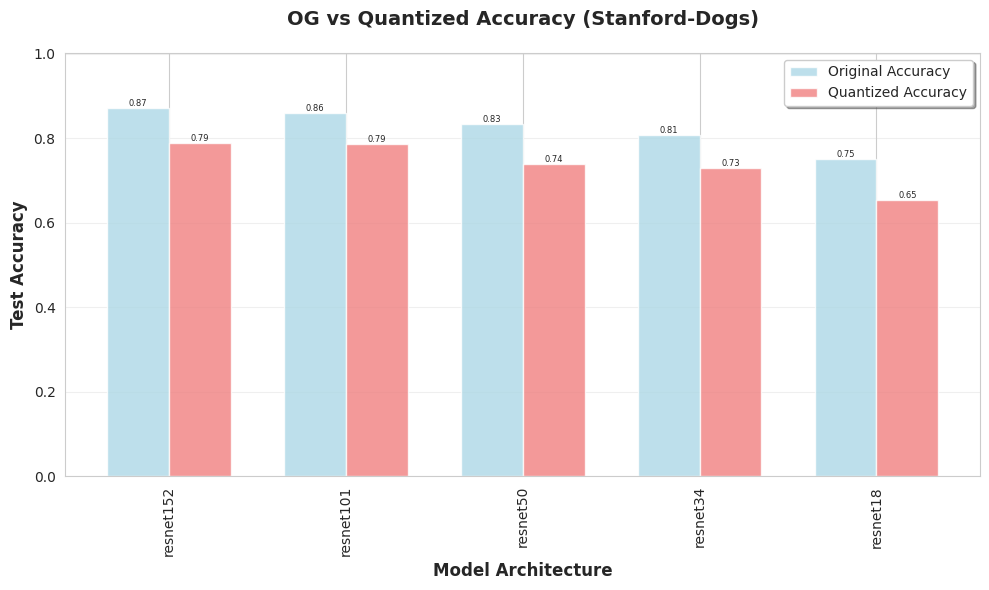

In [44]:
show_plot(data_2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7dd8a54b-b654-4e26-9ba8-1dc7a02da688' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>